# Bias Detection: ML Modeling Notebook
In this notebook, we're going to:
- vectorize (transform text data into numerical format) TF-IDF
- encode our data
- split it into train and test
- train 3 models to predict type of political bias 
- check which model works best 

**Target column**: Bias

In [2]:
# Import libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn. preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, PrecisionRecallDisplay

In [3]:
# Load cleaned data
df = pd.read_csv('../data/cleaned_df.csv')


### Vectorization
Vectorization turns text into numbers so that machine learning models can understand it.
We'll use TF-IDF (Term Frequency-Inverse Document Frequency) which highlights words that are important to a specific article but not common across all articles.


In [4]:
# We limit to the top 5,000 most important words to reduce noise and keep training efficient
tfidf = TfidfVectorizer(max_features=5000)

# Convert clean_text into a matrix of TF-IDF features
X = tfidf.fit_transform(df['clean_text'])


In [5]:

# Sanity check: print the shape to see if it worked
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (2738, 5000)


The TF-IDF matrix has 2,738 rows (articles) and 5,000 columns (unique terms). This means each article is represented as a sparse vector with 5,000 weighted features. This high-dimensional representation captures word importance while reducing noise from common words.

### Encode Labels
Our labels are strings like "left", "right", etc., but ML models work better with numbers.
We'll map each bias category to a number (left = 0, right = 4, etc.)

In [6]:
bias_map = {
    'left': 0,
    'lean left': 1,
    'center': 2,
    'lean right': 3,
    'right': 4
}

# Make sure to only keep rows where the bias is one of our defined categories
df = df[df['Bias'].isin(bias_map.keys())]

# Apply the mapping to convert text labels to numeric labels
y = df['Bias'].map(bias_map)


Class 0 (neutral/center bias) dominates with 1,350 samples, while class 3 (lean right) has the fewest with 207. This imbalance can affect model performance by making it biased toward the majority class unless techniques like resampling or class weighting are used.

In [7]:

# Sanity check: confirm label distribution
print("Label counts:\n", y.value_counts().sort_index())

Label counts:
 Bias
0    1350
1     404
2     270
3     207
4     507
Name: count, dtype: int64


### Train/Test Split
We need to split the data into training and test sets.
The model learns patterns from the training set and is evaluated on the test set to see how well it generalizes.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:

# Sanity check: print the shape of splits
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 2190
Testing samples: 548


The data was split into 80% training and 20% testing sets. This is a typical and balanced way to validate model performance without overfitting or underfitting.

### Model Training
Let's train three different models and compare their accuracy:
- 1. Logistic Regression (a good baseline)
- 2. Naive Bayes (commonly used for text classification)
- 3. Decision Tree (to see how it performs on structured patterns)

In [10]:
# Define our models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier()
}

# Train each model and print its accuracy
for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{name} accuracy: {accuracy:.2f}")

Logistic Regression accuracy: 0.74
Naive Bayes accuracy: 0.55
Decision Tree accuracy: 0.75


Base Logistic Regression Accuracy: 0.74
- The logistic regression model initially performed decently with 74% accuracy. However, due to class imbalance, accuracy may not reflect how well the model performs on minority classes.

Base Decision Tree Accuracy: 0.77
- The untuned decision tree had slightly better performance, possibly because trees can capture nonlinear patterns. However, they tend to overfit, so hyperparameter tuning is essential.

### Fine-tuning the models
We'll try improving our Logistic Regression and Decision Tree models.
For Logistic Regression: We'll tune regularization strength (C) and solver.
For Decision Tree: We'll limit the depth of the tree to prevent overfitting.

In [11]:
# Logistic Regression tuning
log_reg_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
log_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_reg_params, cv=5)
log_grid.fit(X_train, y_train)
print("Best Logistic Regression params:", log_grid.best_params_)
print("Best Logistic Regression accuracy:", log_grid.score(X_test, y_test))

# Decision Tree tuning
tree_params = {
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 10, 20]
}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5)
tree_grid.fit(X_train, y_train)
print("Best Decision Tree params:", tree_grid.best_params_)
print("Best Decision Tree accuracy:", tree_grid.score(X_test, y_test))

Best Logistic Regression params: {'C': 10, 'solver': 'liblinear'}
Best Logistic Regression accuracy: 0.822992700729927
Best Decision Tree params: {'max_depth': 50, 'min_samples_split': 2}
Best Decision Tree accuracy: 0.7664233576642335


Tuned Logistic Accuracy: 0.8248
Best parameters: {'C': 10, 'solver': 'liblinear'}
- Tuning improved accuracy to ~82%, indicating that stronger regularization helped the model better separate the classes. This suggests the model benefited from optimization without overfitting.

Tuned Decision Tree Accuracy: 0.7573
Best parameters: {'max_depth': 50, 'min_samples_split': 2}
- Although the tree was tuned, performance dropped slightly, confirming potential overfitting. A depth of 50 is still quite deep, so simpler models like logistic regression might generalize better here.

### Precision-Recall Curve
Precision-Recall curves help us understand how well the model is distinguishing between classes.
We'll use the fine-tuned logistic regression model since it handles imbalanced data better.

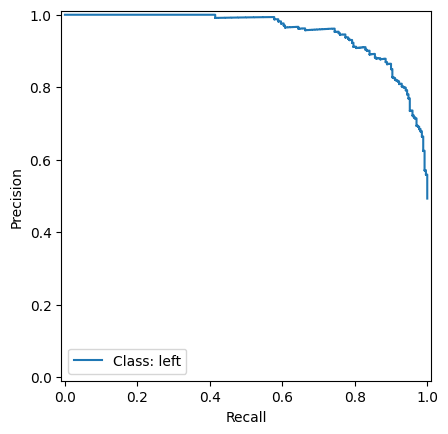

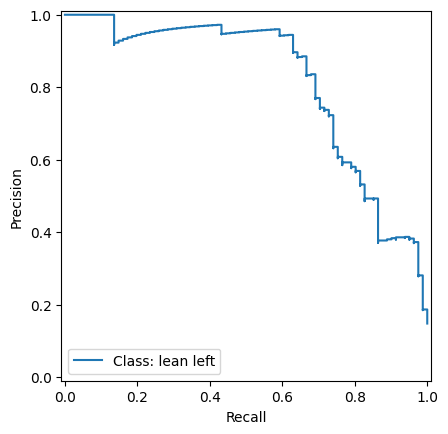

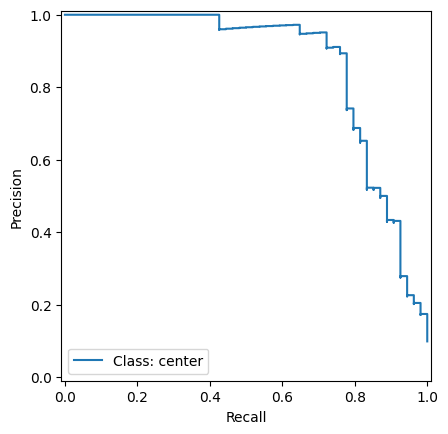

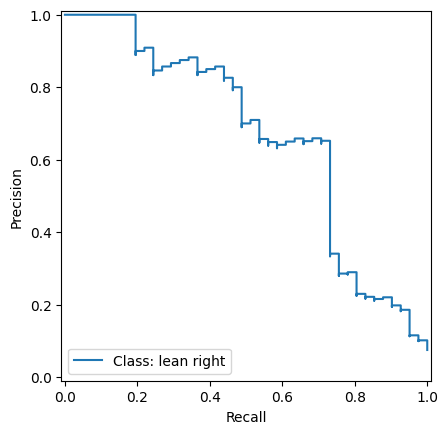

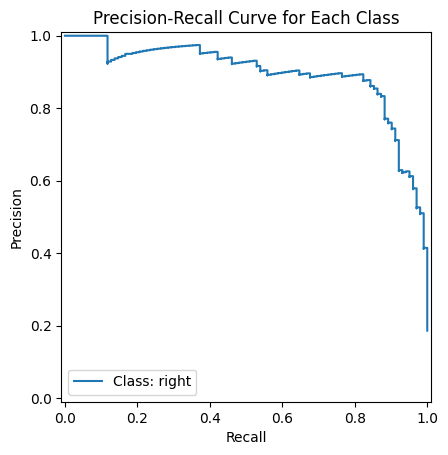

In [12]:
# Binarize labels for multiclass PR curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_scores = log_grid.decision_function(X_test)

# Plot PR curve for each class
for i, class_label in enumerate(bias_map.keys()):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot(name=f"Class: {class_label}")

plt.title("Precision-Recall Curve for Each Class")
plt.show()


**Class: Left**
The precision-recall curve for the "left" class is strong, with high precision and recall values across the board. This suggests the model is very confident and accurate in predicting left-leaning bias — likely due to a larger sample size and distinct word patterns.

**Class: Lean-left**
This class has a relatively high area under the curve (AUC), indicating good precision-recall tradeoff. The curve is consistently above 0.5, suggesting the model is confident in identifying class 0.

**Class: Center**
This class has a steeper drop-off in precision as recall increases, suggesting the model tends to misclassify or over-predict this class under certain conditions.
The sharp decline also indicates an imbalanced dataset or weaker model confidence for that specific class.

### Feature Importance (Top TF-IDF Features)
Logistic Regression gives us coefficients for each feature.
We'll match the top features (words) associated with each bias class.

In [13]:
feature_names = tfidf.get_feature_names_out()
coefs = log_grid.best_estimator_.coef_

# Plot top 10 positive and negative words for each class
for i, label in enumerate(bias_map.keys()):
    top_positive_indices = np.argsort(coefs[i])[-10:]
    top_negative_indices = np.argsort(coefs[i])[:10]
    top_words = [(feature_names[j], coefs[i][j]) for j in top_positive_indices] + \
                [(feature_names[j], coefs[i][j]) for j in top_negative_indices]

    print(f"\n🔠 Top words for class '{label}':")
    for word, weight in top_words:
        print(f"{word}: {weight:.3f}")


🔠 Top words for class 'left':
washington: 3.447
click: 3.457
maga: 3.928
link: 4.860
associ: 5.077
huffpost: 5.719
presidentelect: 5.814
trumpâ: 6.362
read: 14.066
ap: 16.567
breitbart: -6.928
presid: -5.205
news: -4.749
today: -4.111
sign: -4.082
app: -4.056
npr: -4.033
cooki: -3.579
dc: -3.458
stori: -3.450

🔠 Top words for class 'lean left':
dont: 3.441
zoo: 3.631
kennedi: 3.728
edit: 3.866
today: 3.938
âˆ: 4.286
npr: 6.802
usa: 6.861
abc: 7.128
said: 8.004
trumpâ: -8.448
ap: -7.690
read: -5.682
itâ: -5.588
œi: -4.863
œthe: -4.323
januari: -3.599
illeg: -3.398
breitbart: -3.376
donâ: -3.375

🔠 Top words for class 'center':
stori: 4.384
download: 4.454
email: 4.457
app: 4.636
reason: 4.693
camera: 4.922
factsâ: 4.985
uptod: 5.040
straight: 5.150
unbias: 5.335
read: -5.034
said: -4.152
ap: -3.768
trump: -3.063
œthe: -2.409
breitbart: -2.257
health: -2.171
itâ: -2.148
call: -2.085
full: -2.019

🔠 Top words for class 'lean right':
heritag: 2.837
bibl: 2.896
comb: 2.989
allegedli: 3.430

## Intro to Deep Learning 
- We'll implement a basic deep learning model using Keras and TensorFlow.

In [14]:
# Convert TF-IDF matrix to dense format
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [15]:
# One-hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)


2025-04-14 20:07:28.015208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Build a simple dense neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(5000,)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))  # 5 classes


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train_oh, epochs=10, batch_size=32, validation_data=(X_test_dense, y_test_oh))


Epoch 1/10
69/69 [==============================] - 2s 21ms/step - loss: 1.3022 - accuracy: 0.5032 - val_loss: 1.0490 - val_accuracy: 0.5693
Epoch 2/10
69/69 [==============================] - 1s 17ms/step - loss: 0.6724 - accuracy: 0.7804 - val_loss: 0.5880 - val_accuracy: 0.7883
Epoch 3/10
69/69 [==============================] - 1s 17ms/step - loss: 0.2216 - accuracy: 0.9370 - val_loss: 0.5169 - val_accuracy: 0.8303
Epoch 4/10
69/69 [==============================] - 1s 18ms/step - loss: 0.0726 - accuracy: 0.9900 - val_loss: 0.5447 - val_accuracy: 0.8358
Epoch 5/10
69/69 [==============================] - 1s 17ms/step - loss: 0.0337 - accuracy: 0.9945 - val_loss: 0.5810 - val_accuracy: 0.8303
Epoch 6/10
69/69 [==============================] - 1s 18ms/step - loss: 0.0203 - accuracy: 0.9963 - val_loss: 0.6032 - val_accuracy: 0.8303
Epoch 7/10
69/69 [==============================] - 1s 17ms/step - loss: 0.0205 - accuracy: 0.9954 - val_loss: 0.6116 - val_accuracy: 0.8376
Epoch 8/10
69

The deep learning model shows rapid improvement in accuracy, rising from 50% to ~99% on training data over 10 epochs, while validation accuracy plateaus around 83–84% after epoch 4. This suggests the model is overfitting, as training loss continues to decrease but validation loss increases slightly over time.

### Model Evaluation

In [18]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_dense, y_test_oh)
print(f"Deep Learning Accuracy: {accuracy:.4f}")


18/18 [==============================] - 0s 2ms/step - loss: 0.6541 - accuracy: 0.8285
Deep Learning Accuracy: 0.8285


On the test set, the model achieved an accuracy of 82.85%, which is consistent with the validation accuracy. This indicates that while the model performs well, its ability to generalize may be limited by mild overfitting.

### Learning Curves

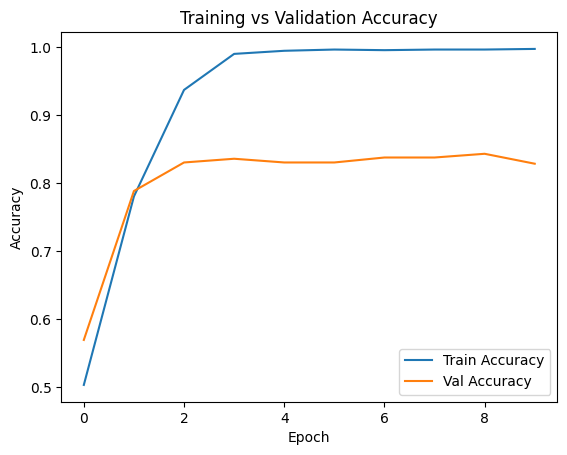

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.68      0.97      0.80       270
           1       0.80      0.53      0.64        81
           2       0.94      0.56      0.70        54
           3       1.00      0.10      0.18        41
           4       0.91      0.66      0.76       102

    accuracy                           0.74       548
   macro avg       0.86      0.56      0.62       548
weighted avg       0.79      0.74      0.71       548



<Axes: >

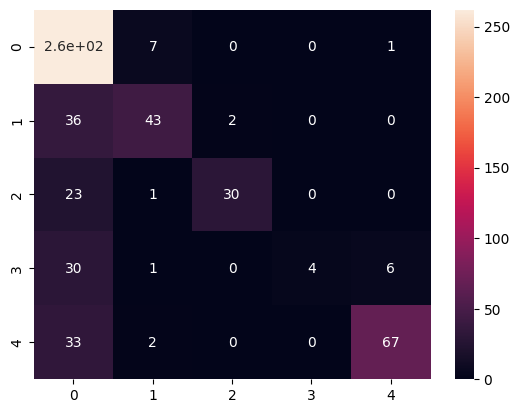

In [25]:

import seaborn as sns

y_pred = models["Logistic Regression"].predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

The Logistic Regression model achieved 74% accuracy, but performance across classes is uneven. Class 0 is predicted well (precision = 0.68, recall = 0.97), while Classes 3 and 2 suffer from low recall (0.10 and 0.56), suggesting the model struggles to correctly identify some classes. The macro average recall of 0.56 indicates class imbalance or limited model capacity for the smaller classes, even though the weighted metrics are more favorable.